# Imports

In [ ]:
#install package
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas
from keras.utils import np_utils
import zipfile
import os
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout , BatchNormalization, Activation, concatenate
from matplotlib import pyplot as plt

In [ ]:
from keras_cv.layers import DropBlock2D

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


#Data

In [ ]:
#Data_path
train_img_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Data_aug_NO_normalized/')

In [ ]:
# read Data and Labels

dir=train_img_dir
classes=[clas.name for clas in os.scandir(dir) if clas.is_dir()]

X,y=[],[]
for clas in tqdm(classes):
    path=os.path.join(dir,clas)
    for img in os.listdir(path):
        X.append(plt.imread(os.path.join(path,img))[:,:,:3])
        y.append(str(clas))

100%|██████████| 6/6 [05:17<00:00, 52.96s/it]


In [ ]:
X=np.array(X)

In [ ]:
#making one-hot output
Y=pandas.get_dummies(y)

In [ ]:
#split data to train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True)

In [ ]:
#split test dataset to test,validation

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,shuffle=True)

# Model

In [ ]:
#def for rate in DropBlock2D

def rate_fun(k_prob,f_size):
  rate_num=((1-k_prob)/(7**2))*((f_size**2)/(f_size-7+1))
  return rate_num

In [ ]:
#DenseLayer function

def DenseLayer(input_layer,rate):
  conv1 = Conv2D(32, kernel_size = (1,1),padding="same")(input_layer)
  BN1=BatchNormalization()(conv1)
  AF1=Activation(activation="swish")(BN1)
  DB1=DropBlock2D(rate,block_size=7)(AF1)
  conv2 = Conv2D(32, kernel_size = (1,1),padding="same")(DB1)
  BN2=BatchNormalization()(conv2)
  AF2=Activation(activation="swish")(BN2)
  DB2=DropBlock2D(rate,block_size=7)(AF2)
  output=DB2
  return output


In [ ]:
#DenseBlock function

def DenseBlock(input_layer,rate):
  DenseLayer1=DenseLayer(input_layer,rate)
  in1 = concatenate([DenseLayer1, input_layer], axis=-1)
  DenseLayer2=DenseLayer(in1,rate)
  in2 = concatenate([DenseLayer2, in1], axis=-1)
  DenseLayer3=DenseLayer(in2,rate)
  in3 = concatenate([DenseLayer3, in2], axis=-1)
  DenseLayer4=DenseLayer(in3,rate)
  in4 = concatenate([DenseLayer4, in3], axis=-1)
  output=in4
  return output


In [ ]:
#Dense Inception function

def D_Inception_block(input_layer, f1, f2_conv1,rate ):

  Iconv1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'swish')(input_layer)
  Iconv1=DropBlock2D(rate,block_size=7)(Iconv1)
  Dense=DenseBlock(input_layer,rate)
  Iconv2 = Conv2D(filters = f2_conv1, kernel_size = (3,3), padding = 'same', activation = 'swish')(input_layer)
  Iconv2=DropBlock2D(rate,block_size=7)(Iconv2)

  output_layer = concatenate([Iconv1,Dense, Iconv2], axis = -1)

  return output_layer

In [ ]:
# optimized GoogLeNet model function

def optimized_GoogLeNet():
  # input layer
  input_layer = Input(shape = (100, 100, 3))

  # convolutional layer: filters = 32, kernel_size = (7,7)
  X = Conv2D(filters = 32, kernel_size = (7,7),strides = 2,padding="same")(input_layer)
  X=BatchNormalization()(X)
  X=Activation(activation="swish")(X)
  rate1=rate_fun(0.95,32)
  X=DropBlock2D(rate1,block_size=7)(X)


  # max-pooling layer: pool_size = (3,3), strides = 1
  X = MaxPooling2D(pool_size = (3,3), strides = 1,padding="same")(X)

  # convolutional layer: filters = 32, kernel_size = (1,1)
  X = Conv2D(filters = 32, kernel_size = (1,1))(X)
  X=BatchNormalization()(X)
  X=Activation(activation="swish")(X)
  X=DropBlock2D(rate1,block_size=7)(X)


  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2,padding="same")(X)

  # 1st Inception block
  rate2=rate_fun(0.9,32)
  X = D_Inception_block(X, f1 = 32, f2_conv1 = 32 , rate=rate2)

  # 2nd Inception block
  X = D_Inception_block(X, f1 = 32, f2_conv1 = 32,rate=rate2)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2,padding="same")(X)

  # 3rd Inception block
  rate3=rate_fun(0.85,64)
  X = D_Inception_block(X, f1 = 64, f2_conv1 = 64,rate=rate3)

  # 4th Inception block
  X = D_Inception_block(X, f1 = 64, f2_conv1 = 64,rate=rate3)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2,padding="same")(X)

  # 5th Inception block
  rate4=rate_fun(0.8,128)
  X = D_Inception_block(X, f1 = 128, f2_conv1 = 128,rate=rate4)
  # 6th Inception block
  X = D_Inception_block(X, f1 = 128, f2_conv1 = 128,rate=rate4)

# Average-pooling layer: pool_size = (7,7), strides = 1
  X1 = AveragePooling2D(pool_size = (7,7), strides = 1)(X)

  X1 = Flatten()(X1)
  X1 = Dense(512, activation = 'swish')(X1)
  X1 = Dropout(0.6)(X1)
  X1 = Dense(6, activation = 'softmax')(X1)



  # model
  model = Model(input_layer, X1, name = 'GoogLeNet')

  return model

In [ ]:
model=optimized_GoogLeNet()

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(monitor='accuracy',factor=0.9,patience=2)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#train model
history=model.fit(X_train,y_train, epochs=200, batch_size=64,validation_data=(X_val,y_val),callbacks=[reduce_lr], shuffle=True)

Epoch 1/200
161/161 [==============================] - 116s 225ms/step - loss: 7.7486 - accuracy: 0.6863 - val_loss: 3.2077 - val_accuracy: 0.4845 - lr: 0.0100
Epoch 2/200
161/161 [==============================] - 31s 195ms/step - loss: 0.3740 - accuracy: 0.8703 - val_loss: 0.9074 - val_accuracy: 0.7671 - lr: 0.0100
Epoch 3/200
161/161 [==============================] - 31s 190ms/step - loss: 0.1411 - accuracy: 0.9549 - val_loss: 0.1084 - val_accuracy: 0.9627 - lr: 0.0100
Epoch 4/200
161/161 [==============================] - 30s 188ms/step - loss: 0.0992 - accuracy: 0.9683 - val_loss: 0.1085 - val_accuracy: 0.9534 - lr: 0.0100
Epoch 5/200
161/161 [==============================] - 30s 184ms/step - loss: 0.0674 - accuracy: 0.9783 - val_loss: 0.0434 - val_accuracy: 0.9860 - lr: 0.0100
Epoch 6/200
161/161 [==============================] - 30s 184ms/step - loss: 0.0708 - accuracy: 0.9775 - val_loss: 0.0667 - val_accuracy: 0.9689 - lr: 0.0100
Epoch 7/200
161/161 [========================

# Evaluation

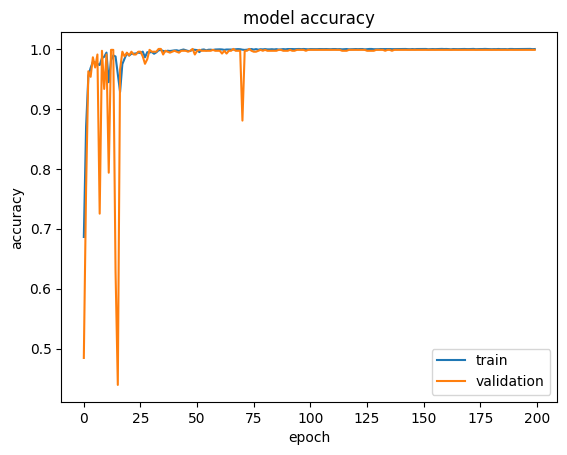

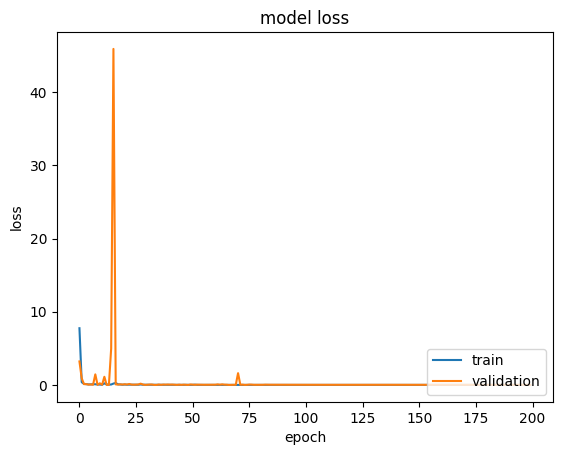

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
#predict test datas
y_pred = model.predict(X_test)

81/81 [==============================] - 5s 29ms/step


In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
y_test2=np.array(y_test.values.tolist())
y_test2=y_test2.argmax(axis=1)

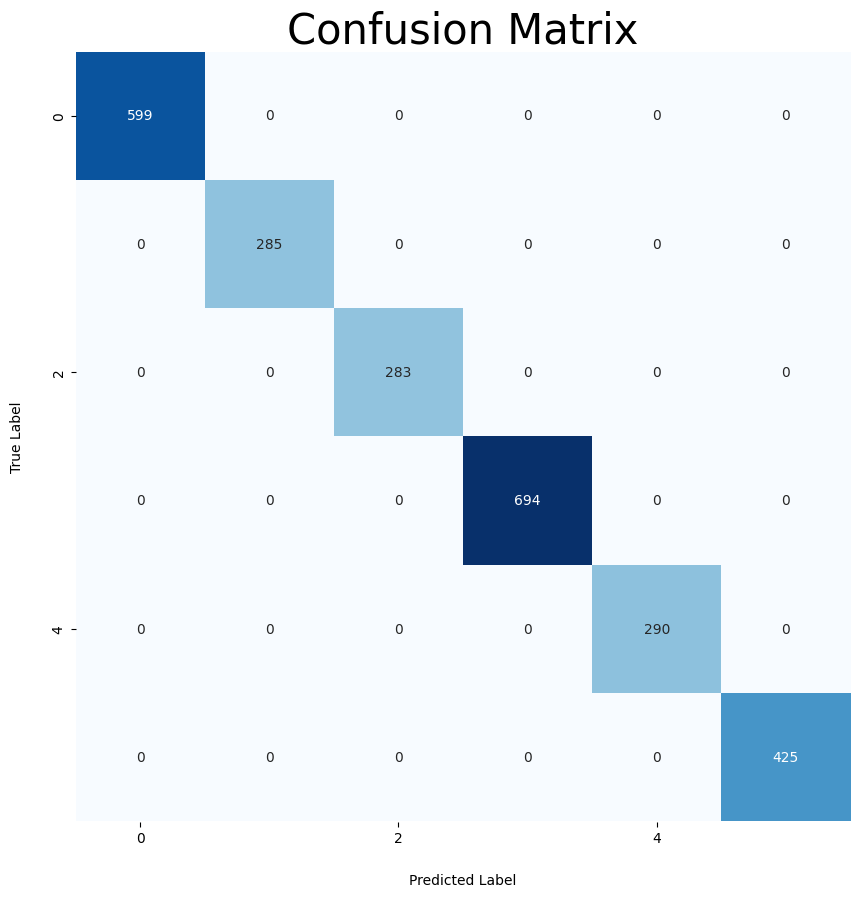

In [ ]:
#plot confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
CM = confusion_matrix(y_test2,y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(CM, cmap='Blues', annot=True, cbar=False, fmt=".0f",xticklabels=2, yticklabels=2)
plt.xlabel('Predicted Label', labelpad=20)
plt.ylabel('True Label', labelpad=20)
plt.title('Confusion Matrix', fontsize=30);

In [ ]:
#model accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test2, y_pred)

1.0

In [ ]:
#model precision score
from sklearn.metrics import precision_score
precision_score(y_test2, y_pred,average='weighted')

1.0

In [ ]:
#model recall score
from sklearn.metrics import recall_score
recall_score(y_test2, y_pred,average='weighted')

1.0

In [ ]:
#model f1 score
from sklearn.metrics import f1_score
f1_score(y_test2, y_pred,average='weighted')

1.0

In [ ]:
#model loss
from sklearn.metrics import zero_one_loss
zero_one_loss(y_test2, y_pred)

0.0